# Inserting Thoth Analysis Documents into JanusGraph

This data was recorded while inserting some Thoth analysis documents into JanusGraph. The import is done via the "Syncing data to JanusGraph" notebook. JanusGraph is running on an OpenStack instance.

First of all let's load the data into a Pandas DataFram

In [62]:
from io import StringIO

import pandas as pd


data_csv="""processed_documents_total, documents_total, vertices_total, edges_total, insert_seconds
1, 29, 903, 3719, 1079.0483193397522
2, 29, 2501, 12150, 2348.4578483104706
3, 29, 3184, 19670, 2190.462992668152
4, 29, 3184, 27721, 2125.468581199646
5, 29, 3445, 32043, 1262.4487073421478
6, 29, 3517, 37505, 1645.9162828922272
7, 29, 3833, 41282, 1087.1923644542694
8, 29, 3856, 44851, 1034.6089341640472
9, 29, 3856, 48451, 1037.8934881687164
10, 29, 3908, 52177, 1115.457729101181
11, 29, 3908, 55607, 1040.4953770637512
12, 29, 3980, 62542, 2037.6315722465515
13, 29, 3980, 69781, 2122.2617712020874
14, 29, 3980, 74002, 1269.0383327007294
15, 29, 3980, 80907, 2019.1456174850464
16, 29, 4002, 87356, 1888.7892897129059
17, 29, 4003, 93793, 1867.0556786060333
18, 29, 4003, 100230, 1859.4741747379303
19, 29, 4003, 106667, 1835.3830652236938
20, 29, 4003, 113572, 2110.4713323116302
21, 29, 4012, 120018, 1881.937932729721
22, 29, 4012, 126455, 1695.1537792682648
23, 20, 4012, 133694, 2010.2911307811737
24, 20, 4012, 140132, 1729.1528384685516
24, 29, 4012, 140132, 1729.1528384685516
25, 29, 4012, 148183, 1925.901031255722
26, 29, 4012, 153628, 1129.053864479065
27, 29, 4012, 160066, 1350.2611811161041
28, 29, 4012, 164287, 1181.451013326645
29, 29, 4012, 167717, 872.3602607250214
"""

f = StringIO(data_csv)
df = pd.read_csv(f)


Having a short look at the structure gives an idea of the growth of the graph database and the time it took to insert:

 * We have about 4000 Vertices and 160k Edges.
 * It took around 28 minutes to insert each analyser document.

In [63]:
df.describe()

,processed_documents_total,documents_total,vertices_total,edges_total,insert_seconds
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.300000,28.400000,3738.300000,87277.933333,1616.047244
std,8.526429,2.283373,636.428567,50000.728280,442.714273
min,1.000000,20.000000,903.000000,3719.000000,872.360261
25%,8.250000,29.000000,3856.000000,45751.000000,1142.153152
50%,15.500000,29.000000,3991.000000,84131.500000,1729.152838
75%,22.750000,29.000000,4012.000000,131884.250000,1989.193606
max,29.000000,29.000000,4012.000000,167717.000000,2348.457848


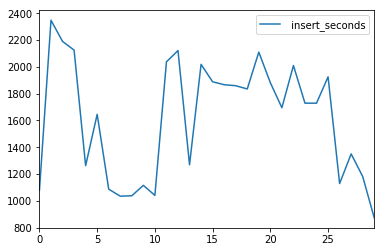

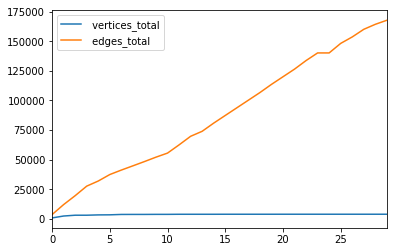

In [64]:
import matplotlib.pyplot as plt


%matplotlib inline


df.iloc[:,4:5].plot()
df.iloc[:,2:4].plot()

In [81]:
from thoth.storages.graph import GraphDatabase
from thoth.lab import GraphQueryResult as gqr

graph_db = GraphDatabase.create('10.8.253.255', port=8182)
graph_db.connect()
g = graph_db.g   # We will use raw Gremlin traversal in examples.

It's worth to note that the queried JanusGraph instance in this case has indexes and schema configured that has significant impact on performance. On the other hand it runs in a verbose mode that causes performance drawbacks.

Before we start, let's perform imports of some objects we will use later on in the queries to keep notebook cells minimal for demonstration:

In [82]:
import timeit
from pprint import pprint
from thoth.solver import pip_compile
from gremlin_python.process.graph_traversal import has
from gremlin_python.process.traversal import Operator
from gremlin_python.process.traversal import Pop
from gremlin_python.process.traversal import not_
from gremlin_python.process.graph_traversal import identity
from gremlin_python.process.graph_traversal import outE
from gremlin_python.process.graph_traversal import out
from gremlin_python.process.graph_traversal import inE
from gremlin_python.process.graph_traversal import select
from gremlin_python.process.graph_traversal import values
from gremlin_python.process.graph_traversal import fold
from gremlin_python.process.graph_traversal import constant
from gremlin_python.process.graph_traversal import project

Let's query the graph database, we use a pretty simple query: find all version of python packages jinja2 and markupsafe.

In [113]:
# %%timeit

def do_slow_query():
    return gqr(
        g.V()
        .has('ecosystem', 'pypi')
        .has('__label__','python_package_version') # .has('__type__','vertex')
        .or_(has('package_name', 'jinja2'), has('package_name', 'markupsafe'))
        .order().by('package_version')
        .project('package', 'version').by('package_name').by('package_version')
        .toList()
    )

def do_fast_query():
    return gqr(
        g.V()
        .has('ecosystem', 'pypi')
        .has('__label__','python_package_version').has('__type__','vertex')
        .or_(has('package_name', 'jinja2'), has('package_name', 'markupsafe'))
        .order().by('package_version')
        .project('package', 'version').by('package_name').by('package_version')
        .toList()
)

%timeit do_slow_query()
%timeit do_fast_query()


789 ms ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
188 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see, the second query is significantly faster than the first, even though they deliver the same results. But the second query is using the indices in the correct way: in the way they were created, not ommiting one attribute of the composed index.